In [118]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import math

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
plt.style.use('scientific')

In [119]:
def simulate(delays, weights, origins, inputs, Q=10, R=10):
    spikes_df = [pd.DataFrame.from_dict({"neuron": torch.arange(L).repeat_interleave(M + 1), "spike": inputs.view(-1)})]

    for q in range(1, Q+1):
        print(f"cycle {q}/{Q}")
        for n in tqdm(range(N)):
            for r in range(R):
                t = q * N + n + r / R
                z = (impulse_resp(t - inputs[origins] - delays[...,None]).sum(dim=-1) * weights).nansum(dim=1)

                neurons = torch.argwhere(((t - inputs[:, 0]) > Nr) & (z >= theta)).view(-1)

                if neurons.numel() > 0:
                    inputs[neurons, 1:] = inputs[neurons, :-1]
                    inputs[neurons, 0] = t
                    spikes_df.append(pd.DataFrame.from_dict({"neuron": neurons, "spike": t}))
                    
    return pd.concat(spikes_df)

In [120]:
def get_inputs(run_name, noise_lim=(0,0)):
    spike_sequences = pd.read_csv(run_name + "spike-sequences.csv")
    spike_sequences = pd.concat(
        (
            spike_sequences, 
            pd.DataFrame.from_dict({"neuron": torch.arange(L).repeat_interleave(M + 1), "spike": -1e9})
        )
    ) # add default values if not M+1 last spikes
    
    last_spikes = torch.tensor(spike_sequences.groupby("neuron").spike.nlargest(M+1, "last").values).view(L, M+1)
    
    noise = torch.FloatTensor(L, M+1).uniform_(*noise_lim)
    #noise = torch.zeros(L, M+1)
    #noise[0,0] = noise_lvl

    return last_spikes + noise, noise


In [121]:
def plot_cycle(df_sim, df_true, q, l, name):
    fig, ax = plt.subplots(figsize=(20, 1))
    
    df_sim["value"] = 1
    df_true["value"] = 1
    
    mask_sim = (N * q <= df_sim.spike) & (df_sim.spike < N * (q+1)) & (df_sim.neuron == l)
    mask_true = (df_true.neuron == l)
    
    ax.stem(df_sim[mask_sim].spike, df_sim[mask_sim].value, basefmt=" ", linefmt="C1-", markerfmt="C1o")
    ax.stem(df_true[mask_true].spike + q * N, df_true[mask_true].value, basefmt=" ", linefmt="C0--", markerfmt="C0o")

    ax.legend(["sim", "true"], loc="center left")
    ax.set_ylim(-0.1, 1.3)
    ax.set_xlim(q*N - 20, (q+1)*N + 1)
    ax.xaxis.set_major_locator(MultipleLocator(N))
    ax.yaxis.set_major_locator(MultipleLocator(10))
    ax.set_title(name)

In [142]:
L, K, N, Nr, M = 200, 400, 100, 20, 3
theta = 1
impulse_resp = lambda t_: (t_ >= 0) * t_/2 * torch.exp(1 - t_/2)
impulse_resp_deriv = lambda t_: 1 / 2 * (1 - t_ / 2) * torch.exp(1 - t_ / 2) * (t_ >= 0)

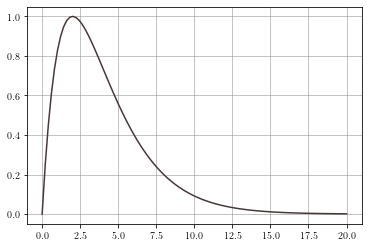

In [123]:
t = torch.linspace(0, Nr, 100)
plt.plot(t, impulse_resp(t))
plt.show()

# Theoretically stable network / sequence

In [124]:
# without zdotmin constraint

In [125]:
run_name = "data/clear-butterfly-136-"

In [126]:
delays = torch.load(run_name + "delays.pt")
origins = torch.load(run_name + "origins.pt")
weights = torch.load(run_name + "weights.pt")

In [21]:
connectivity_df = pd.DataFrame.from_dict(
    {
        "delays": delays.flatten(), 
        "neuron_sources": origins.flatten(), 
        "neuron_targets": torch.arange(L).repeat_interleave(K),
        "weights": weights.flatten()
    }
)
#_ = connectivity_df.hist(column="delays")

In [22]:
spike_df = pd.read_csv(run_name + "spike-sequences.csv")

In [127]:
def get_summary_df(connectivity_df, spike_df):
    h = lambda t_: (t_>0) * math.exp(1 - t_/2) * t_/2

    new_df = spike_df.merge(spike_df, how="cross", suffixes=["_sources", "_targets"])
    summary_df = new_df.merge(connectivity_df, on=["neuron_sources", "neuron_targets"], how="outer")
    summary_df = summary_df.copy()
    summary_df["time_diff"] = (summary_df.spike_targets - summary_df.spike_sources - summary_df.delays)%N
    summary_df["unweighted_contrib_sources"] = summary_df.time_diff.apply(h)
    summary_df["contrib_sources"] = summary_df.unweighted_contrib_sources * summary_df.weights
    summary_df = summary_df[summary_df.contrib_sources.abs() > 1e-5]
    return summary_df

In [128]:
def get_measure_df(summary_df):
    new_df = summary_df.drop(["spike_sources","spike_targets","delays","weights","time_diff"], axis=1)
    measure_df = new_df.groupby(["neuron_targets", "neuron_sources"]).agg({"contrib_sources": ["min", "max"]})
    return measure_df

In [31]:
summary_df = get_summary_df(connectivity_df, spike_df)
summary_df

,index_sources,neuron_sources,spike_sources,index_targets,neuron_targets,spike_targets,delays,weights,time_diff,unweighted_contrib_sources,contrib_sources
5,0,0,11,2,0,54,36.110626,-0.013542,6.889374,0.298838,-0.004047
6,0,0,11,3,0,78,44.729557,0.100000,22.270443,0.000442,0.000044
14,1,0,32,3,0,78,44.729557,0.100000,1.270443,0.914843,0.091484
15,1,0,32,3,0,78,36.110626,-0.013542,9.889374,0.095716,-0.001296
16,2,0,54,0,0,11,44.729557,0.100000,12.270443,0.036110,0.003611
...,...,...,...,...,...,...,...,...,...,...,...
1021903,1,199,58,2,199,96,28.412676,-0.077339,9.587324,0.107920,-0.008346
1021904,1,199,58,2,199,96,19.040390,-0.066458,18.959610,0.001968,-0.000131
1021906,2,199,96,0,199,17,19.074284,0.064998,1.925716,0.999293,0.064952
1021908,2,199,96,0,199,17,19.040390,-0.066458,1.959610,0.999793,-0.066444


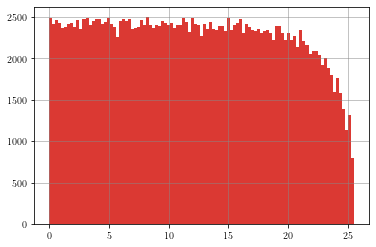

In [32]:
_ = summary_df.time_diff.hist(bins=101, color="C1")

In [33]:
summary_df.corr()

,index_sources,neuron_sources,spike_sources,index_targets,neuron_targets,spike_targets,delays,weights,time_diff,unweighted_contrib_sources,contrib_sources
index_sources,1.000000,-0.021786,0.892770,-0.226847,-0.000073,-0.239007,-0.006172,0.001987,-0.001994,0.000554,0.004597
neuron_sources,-0.021786,1.000000,-0.008367,-0.003382,0.000143,-0.003372,0.001294,-0.003404,-0.001500,0.000505,0.003260
spike_sources,0.892770,-0.008367,1.000000,-0.238936,-0.002017,-0.251967,-0.004911,-0.001857,-0.003293,0.001204,0.001959
index_targets,-0.226847,-0.003382,-0.238936,1.000000,-0.021221,0.892381,0.000456,0.014559,0.000629,0.001732,0.000568
neuron_targets,-0.000073,0.000143,-0.002017,-0.021221,1.000000,-0.005182,-0.002232,-0.001740,-0.001373,0.001041,-0.000146
spike_targets,-0.239007,-0.003372,-0.251967,0.892381,-0.005182,1.000000,-0.001028,0.000625,-0.000864,0.002411,0.000662
delays,-0.006172,0.001294,-0.004911,0.000456,-0.002232,-0.001028,1.000000,-0.002235,-0.000509,0.002454,-0.001135
weights,0.001987,-0.003404,-0.001857,0.014559,-0.001740,0.000625,-0.002235,1.000000,0.017039,0.066539,0.586379
time_diff,-0.001994,-0.001500,-0.003293,0.000629,-0.001373,-0.000864,-0.000509,0.017039,1.000000,-0.808922,-0.186593
unweighted_contrib_sources,0.000554,0.000505,0.001204,0.001732,0.001041,0.002411,0.002454,0.066539,-0.808922,1.000000,0.256929


In [34]:
summary_df.nlargest(20, "contrib_sources")

,index_sources,neuron_sources,spike_sources,index_targets,neuron_targets,spike_targets,delays,weights,time_diff,unweighted_contrib_sources,contrib_sources
349001,2,67,97,1,81,41,41.998245,0.100000,2.001755,1.000000,0.100000
467494,2,89,87,1,80,38,48.996582,0.100000,2.003418,0.999999,0.100000
402347,1,77,56,2,119,82,23.994736,0.100000,2.005264,0.999997,0.100000
998973,3,195,97,0,35,3,3.995039,0.100000,2.004961,0.999997,0.099999
312698,0,59,20,1,196,36,13.993599,0.100000,2.006401,0.999995,0.099999
470974,0,90,15,1,44,35,18.007761,0.100000,1.992239,0.999992,0.099999
66144,0,12,0,1,170,44,41.991673,0.100000,2.008327,0.999991,0.099999
148387,1,28,35,1,61,62,24.989037,0.100000,2.010963,0.999985,0.099999
184589,3,34,94,1,180,41,44.987503,0.100000,2.012497,0.999981,0.099998
89197,2,16,98,0,185,19,18.990633,0.099998,2.009367,0.999989,0.099997


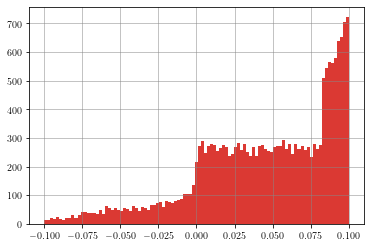

In [35]:
_ = summary_df[summary_df.time_diff < 2].contrib_sources.hist(bins=101, color="C1")

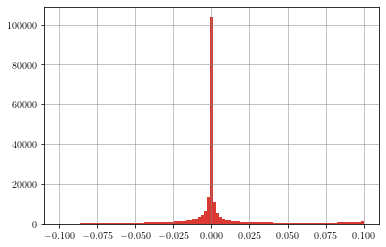

In [36]:
_ = summary_df.contrib_sources.hist(bins=101, color="C1")

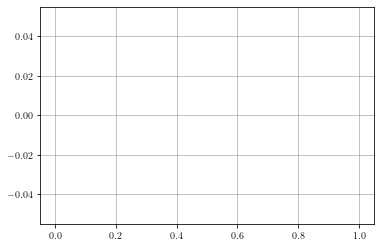

In [37]:
_ = summary_df[(summary_df.neuron_targets == 0) & (summary_df.spike_targets == 31)].contrib_sources.hist(bins=101, color="C1")

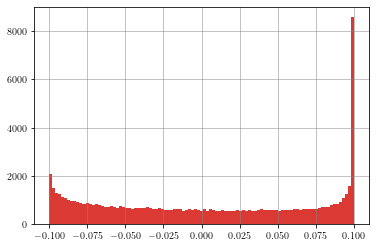

In [38]:
_ = connectivity_df.weights.hist(bins=101, color="C1")

In [39]:
measure_df = get_measure_df(summary_df)
measure_df

contrib_sources          
                                          min       max
neuron_targets neuron_sources                          
0              0                    -0.004047  0.091484
               1                    -0.048268  0.008215
               2                    -0.046727 -0.000369
               3                    -0.009859 -0.000351
               4                    -0.059336 -0.007682
...                                       ...       ...
199            195                  -0.013731  0.006873
               196                  -0.066154  0.099013
               197                  -0.050007  0.016188
               198                   0.000048  0.002491
               199                  -0.066444  0.064952

[34533 rows x 2 columns]

In [144]:
inputs, noise = get_inputs(run_name, noise_lim=(0, 0))

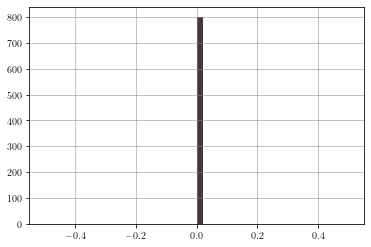

In [145]:
_ = plt.hist(noise.flatten().numpy(), bins=50)

In [146]:
sim_df = simulate(delays, weights.round(decimals=1), origins, inputs.clone(), Q=5, R=1000)

cycle 1/5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:45<00:00,  2.86s/it]


cycle 2/5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:38<00:00,  2.78s/it]


cycle 3/5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:38<00:00,  2.78s/it]


cycle 4/5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:38<00:00,  2.78s/it]


cycle 5/5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:39<00:00,  2.80s/it]


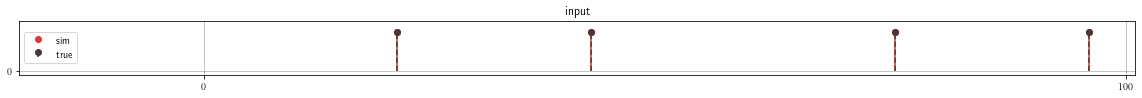

In [147]:
plot_cycle(sim_df, spike_df, 0, 14, "input")

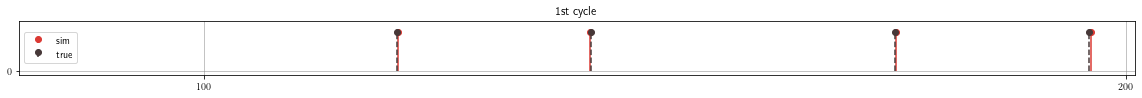

In [148]:
plot_cycle(sim_df, spike_df, 1, 14, "1st cycle")

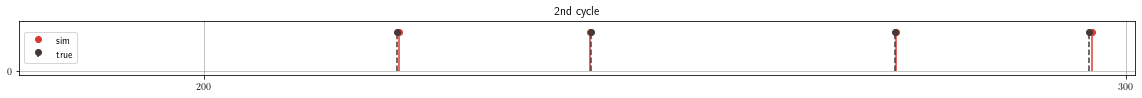

In [149]:
plot_cycle(sim_df, spike_df, 2, 14, "2nd cycle")

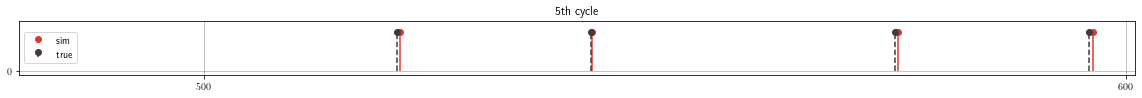

In [150]:
plot_cycle(sim_df, spike_df, 5, 14, "5th cycle")

In [108]:
spike_df[spike_df.neuron == 0]

,index,neuron,spike,value
0,0,0,11,1
1,1,0,32,1
2,2,0,54,1
3,3,0,78,1


In [107]:
sim_df[(sim_df.spike > 500)&(sim_df.neuron == 0)]

,neuron,spike,value
0,0,510.920,1
0,0,531.965,1
0,0,553.876,1
0,0,577.912,1


In [78]:
39-11

28

In [80]:
85-54

31

In [400]:
df_sim[df_sim.spike >= 750]

,neuron,spike,value


In [ ]:
spike_df.groupby("neuron").agg({"value": "sum"}).value[mask]

In [202]:
run_name = "data/frosty-water-120-"

In [203]:
delays = torch.load(run_name + "delays.pt")
origins = torch.load(run_name + "origins.pt")
weights = torch.load(run_name + "weights.pt")

In [204]:
connectivity_df = pd.DataFrame.from_dict(
    {
        "delays": delays.flatten(), 
        "origins": origins.flatten(), 
        "neurons": torch.arange(L).repeat_interleave(K),
        "weights": weights.flatten()
    }
)
#_ = connectivity_df.hist(column="delays")

In [205]:
df_true = pd.read_csv(run_name + "spike-sequences.csv")

In [206]:
inputs, noise = get_inputs(run_name, noise_lvl=0)
df_sim = simulate(delays, weights, origins, inputs.clone(), Q=5, R=100)

cycle 1/5


100%|█████████████████████████████████████████| 250/250 [01:48<00:00,  2.31it/s]


cycle 2/5


100%|█████████████████████████████████████████| 250/250 [01:46<00:00,  2.35it/s]


cycle 3/5


100%|█████████████████████████████████████████| 250/250 [01:46<00:00,  2.35it/s]


cycle 4/5


100%|█████████████████████████████████████████| 250/250 [02:31<00:00,  1.65it/s]


cycle 5/5


100%|█████████████████████████████████████████| 250/250 [02:53<00:00,  1.44it/s]


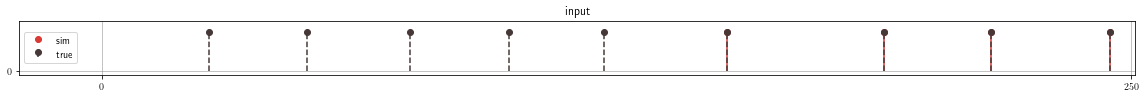

In [207]:
plot_cycle(df_sim, df_true, 0, 101, "input")

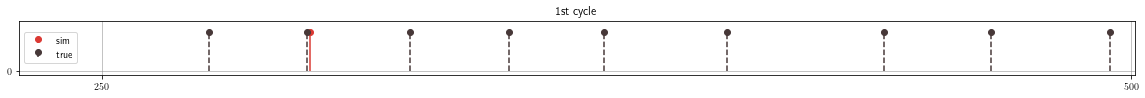

In [208]:
plot_cycle(df_sim, df_true, 1, 101, "1st cycle")

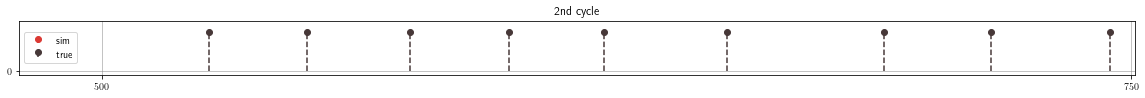

In [209]:
plot_cycle(df_sim, df_true, 2, 101, "2nd cycle")

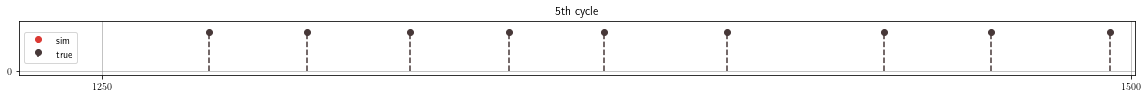

In [210]:
plot_cycle(df_sim, df_true, 5, 101, "5th cycle")

In [16]:
# without zdotmin constraint

In [17]:
run_name = "data/royal-salad-121-"

In [18]:
delays = torch.load(run_name + "delays.pt")
origins = torch.load(run_name + "origins.pt")
weights = torch.load(run_name + "weights.pt")

In [19]:
connectivity_df = pd.DataFrame.from_dict(
    {
        "delays": delays.flatten(), 
        "origins": origins.flatten(), 
        "neurons": torch.arange(L).repeat_interleave(K),
        "weights": weights.flatten()
    }
)
#_ = connectivity_df.hist(column="delays")

In [20]:
df_true = pd.read_csv(run_name + "spike-sequences.csv")

In [34]:
inputs, noise = get_inputs(run_name, noise_lvl=10)
df_sim = simulate(delays, weights, origins, inputs.clone(), Q=5, R=10)

cycle 1/5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:11<00:00, 22.32it/s]


cycle 2/5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:10<00:00, 22.95it/s]


cycle 3/5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:10<00:00, 23.08it/s]


cycle 4/5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:10<00:00, 23.01it/s]


cycle 5/5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:11<00:00, 22.16it/s]


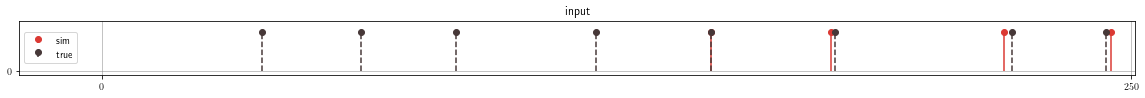

In [35]:
plot_cycle(df_sim, df_true, 0, 10, "input")

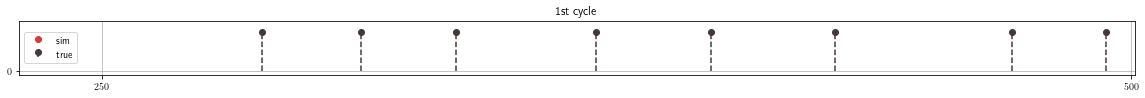

In [36]:
plot_cycle(df_sim, df_true, 1, 10, "1st cycle")

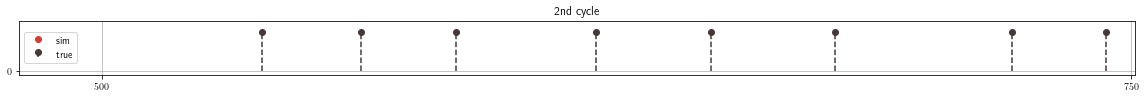

In [37]:
plot_cycle(df_sim, df_true, 2, 10, "2nd cycle")

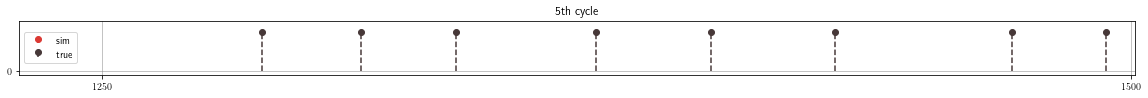

In [38]:
plot_cycle(df_sim, df_true, 5, 10, "5th cycle")

# Limit of linear system...

In [726]:
seq = torch.zeros(N, L, dtype=bool)
seq[spike_sequences.spike.values, spike_sequences.neuron.values] = 1
As = compute_jitter_transition_tensor(seq, weights, delays, origins, Nr, impulse_resp_deriv)

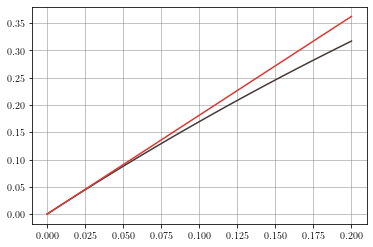

In [736]:
lin_impulse_resp = lambda t_, t0: impulse_resp(t0) + (t_ - t0) * impulse_resp_deriv(t0)
t = torch.linspace(0, 0.2, 100)
plt.plot(t, impulse_resp(t))
plt.plot(t, lin_impulse_resp(t, torch.zeros(1)))
plt.show()

# Theoretically unstable network / sequence

In [672]:
run_name = "data/winter-salad-101-" # should be highly unstable

In [673]:
delays = torch.load(run_name + "delays.pt")
origins = torch.load(run_name + "origins.pt")
weights = torch.load(run_name + "weights.pt")

In [674]:
connectivity_df = pd.DataFrame.from_dict(
    {
        "delays": delays.flatten(), 
        "origins": origins.flatten(), 
        "neurons": torch.arange(L).repeat_interleave(K),
        "weights": weights.flatten()
    }
)
#_ = connectivity_df.hist(column="delays")

In [675]:
df_true = pd.read_csv(run_name + "spike-sequences.csv")

In [676]:
inputs = get_inputs(run_name, noise_lvl=5)
df_sim = simulate(delays, weights, origins, inputs.clone(), Q=3, R=100)

cycle 1/3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [01:51<00:00,  2.24it/s]


cycle 2/3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [01:48<00:00,  2.31it/s]


cycle 3/3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [01:47<00:00,  2.32it/s]


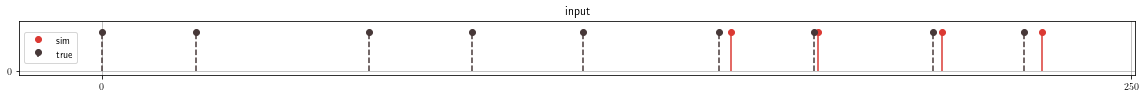

In [677]:
plot_cycle(df_sim, df_true, 0, 4, "input")

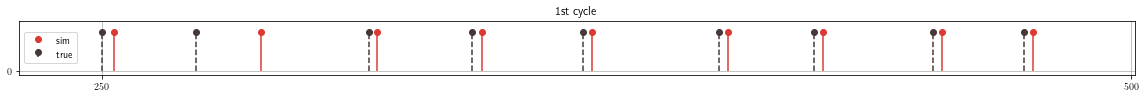

In [678]:
plot_cycle(df_sim, df_true, 1, 4, "1st cycle")

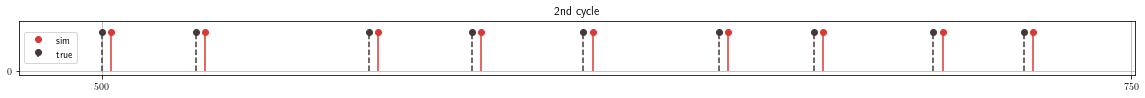

In [679]:
plot_cycle(df_sim, df_true, 2, 4, "2nd cycle")

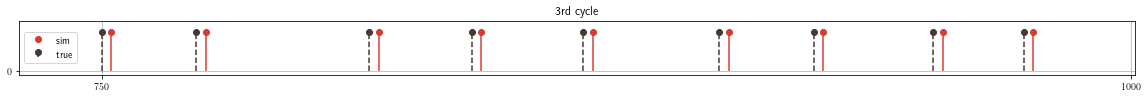

In [680]:
plot_cycle(df_sim, df_true, 3, 4, "3rd cycle")

In [ ]:
# compare with v0 when it is stable

In [681]:
from rsnn.stability.temporal_stability import compute_jitter_transition_tensor

In [689]:
seq = torch.zeros(N, L, dtype=bool)
seq[spike_sequences.spike.values, spike_sequences.neuron.values] = 1
seq

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False,  True, False,  ..., False, False, False],
        ...,
        [False, False,  True,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ...,  True, False, False]])

In [693]:
As = compute_jitter_transition_tensor(seq, weights, delays, origins, Nr, impulse_resp_deriv)

In [701]:
As[0] @ torch.tensor([1.] + ((M+1)*L - 1)*[0.])

tensor([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0168e-06, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+